In [201]:
import numpy as np
import pandas as pd
import scipy.spatial
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = (6.0, 5.0)

In [2]:
def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [152]:
def generate_data(num_of_charges=1,
                  num_of_samples=100,
                  base_charge=1.0,
                  test_case=False):
    
    if test_case:
        num_of_charges=1
        num_of_samples=10000
        base_charge=1.0
        cxyq = np.array((0.5,0.5,base_charge)).reshape(1,3)
    else:
        cxyq = np.append(np.random.uniform(low=0.0,high=base_charge,size=(num_of_charges,2)),
                         np.random.choice([-1.0*base_charge,1.0*base_charge],size=(num_of_charges,1)), axis=1)
    
    pxy = np.random.uniform(size=(num_of_samples,2))
    
    #Calculate the net field
    result = []
    for isam in range(0,num_of_samples):
        f = 0.0
        x = pxy[isam,0]
        y = pxy[isam,1]

        # Average over all the charges
        for ic in range(0,num_of_charges):
            dist = scipy.spatial.distance.euclidean(cxyq[ic,0:2],pxy[isam,0:2])
            f += (cxyq[ic,2]/(dist*dist))
        
        max_mag = 1.0e4
        if f > 0:   
            f = min(f,max_mag)
        else:
            f = max(f,-1.0*max_mag)
        P = np.array([f,x,y])
        C = cxyq.flatten()
        arr = np.hstack((P,C))
        result.append(arr)

    result = np.array(result)
    return result

In [153]:
def make_plot(results,
              use_log=True):
    fig, ax = plt.subplots()
    X = results[:,1]
    Y = results[:,2]
    if use_log:
        Z = np.log(np.abs(results[:,0]))
    else:
        Z = results[:,0]
    xi = np.linspace(min(X), max(X),num=100)
    yi = np.linspace(min(Y), max(Y),num=100)
    zi = griddata(X, Y, Z, xi, yi, interp='linear')
    p = ax.pcolor(xi, yi,zi, cmap=plt.cm.RdBu)
    cb = fig.colorbar(p)
    return fig,ax

In [154]:
result_simple = generate_data(test_case=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2. Use scipy.interpolate.griddata instead.
  if sys.path[0] == '':


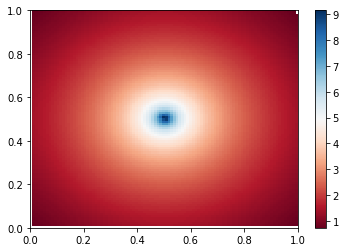

In [155]:
fig,ax = make_plot(result_simple,
                   use_log=True)

In [160]:
data = generate_data(num_of_charges=10,
                     num_of_samples=10000)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2. Use scipy.interpolate.griddata instead.
  if sys.path[0] == '':


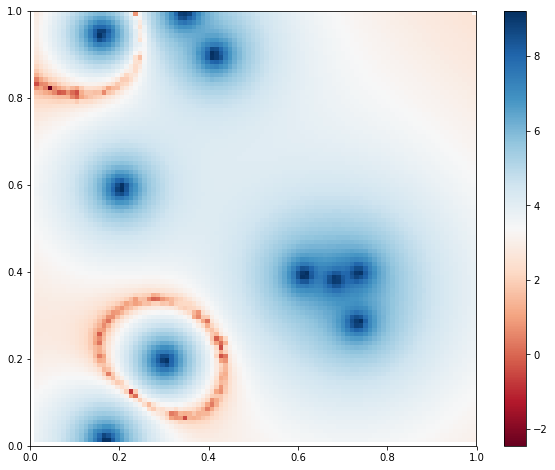

In [163]:
fig,ax = make_plot(data,use_log=True)

### Scale invariant emergent behaviour from charges particles. DeepNN to predict the effect field at any given point. 
* DNN can summarise the function that describes the field given the location of all charged particles
* assume the location of a charged particle point is known (can later simulate measuring this) 
* later - apply the effective force at each point 
* calculate the dynamics from first principles and get the NN to summarise this behaviour (CNN)

In [458]:
### Generate a big dataset for two charges in different places 
def generate_big_dataset(max_n_charge=4,
                         num_of_charge_samples=500,
                         num_of_samples=500):
    
    # Generate the largest charge first
    data = generate_data(num_of_charges=max_n_charge,
                         num_of_samples=num_of_samples)

    # Loop through all other iterations
    for icharge in range(1,num_of_charge_samples):
        data_new = generate_data(num_of_charges=max_n_charge,
                                 num_of_samples=num_of_samples)
        data = np.vstack((data,data_new))
    return data

### Takes some time to generate the entire dataset

In [459]:
data = generate_big_dataset()

In [460]:
df = pd.DataFrame(data)
df.to_csv('charge_data_set_big.csv',index=False)
#df = pd.read_csv('charge_data_set.csv')

In [461]:
df.shape

(250000, 15)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2. Use scipy.interpolate.griddata instead.
  if sys.path[0] == '':


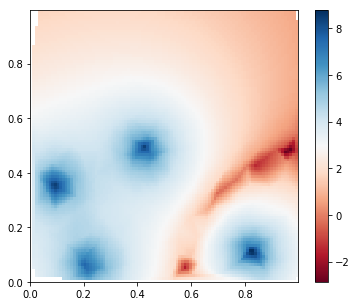

In [462]:
fig,ax = make_plot(df.values[0:500,],use_log=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2. Use scipy.interpolate.griddata instead.
  if sys.path[0] == '':


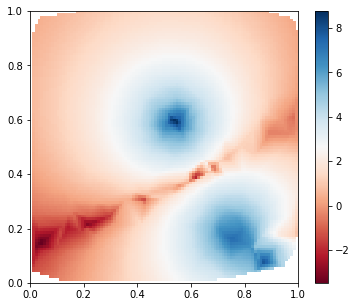

In [464]:
fig,ax = make_plot(df.values[500:1000,],use_log=True)

In [31]:
# fig,ax = make_plot(df.values[40000:49999,],use_log=True)

In [465]:
df.iloc[:,1:].shape

(250000, 14)

In [466]:
feature_dims = df.shape[1]
fdarr = np.arange(1,feature_dims)
X = df.iloc[:,1:].values
Y = np.log(np.abs(df.iloc[:,0].values.reshape(-1,1)))

In [467]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
scaler_target = StandardScaler()
scaler_target.fit(y_train)
y_train  = scaler_target.transform(y_train)
y_test  = scaler_target.transform(y_test)

In [561]:
#### create model
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
model = Sequential()
model.add(Dense(100,input_dim=(feature_dims-1), 
                        kernel_initializer='normal', 
                        activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(500, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(200, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform'))

# Compile model
# adam = keras.optimizers.Adam(lr=1e-2, 
#                              beta_1=0.9, 
#                              beta_2=0.999, 
#                              epsilon=None, 
#                              decay=0.1, 
#                              amsgrad=False)
#mean_absolute_percentage_error
#logcosh
model.compile(loss='mse', optimizer='adam',metrics=['mse'])

In [562]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)
# list all data in history

Train on 140000 samples, validate on 35000 samples
Epoch 1/100
140000/140000 [==============================] - 25s 177us/step - loss: 0.7911 - mean_squared_error: 0.7911 - val_loss: 0.6911 - val_mean_squared_error: 0.6911
Epoch 2/100
140000/140000 [==============================] - 17s 121us/step - loss: 0.6590 - mean_squared_error: 0.6590 - val_loss: 0.5748 - val_mean_squared_error: 0.5748
Epoch 3/100
140000/140000 [==============================] - 17s 124us/step - loss: 0.5622 - mean_squared_error: 0.5622 - val_loss: 0.4716 - val_mean_squared_error: 0.4716
Epoch 4/100
140000/140000 [==============================] - 21s 147us/step - loss: 0.4883 - mean_squared_error: 0.4883 - val_loss: 0.4041 - val_mean_squared_error: 0.4041
Epoch 5/100
140000/140000 [==============================] - 18s 132us/step - loss: 0.4352 - mean_squared_error: 0.4352 - val_loss: 0.3459 - val_mean_squared_error: 0.3459
Epoch 6/100
140000/140000 [==============================] - 18s 129us/step - loss: 0.400

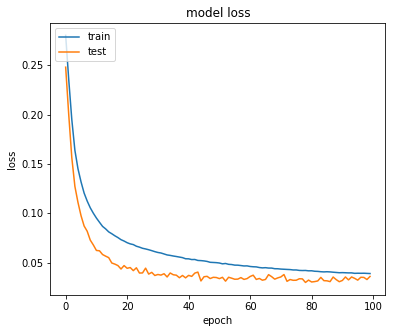

In [540]:
#print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

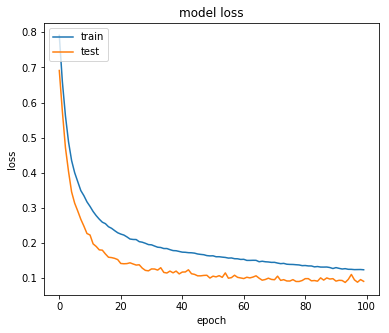

In [563]:
#print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [564]:
# serialize model to JSON
model_json = model.to_json()
with open("model_nn_big_em2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_nn_big_em2.h5")
print("Saved model to disk")

Saved model to disk


### Look at the trained model

In [565]:
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.508012,0.225000,0.218224,0.060713,1.0,0.823252,0.102303,-1.0,0.420906,0.478331,1.0,0.100824,0.351349,1.0
1,0.540530,0.252152,0.218224,0.060713,1.0,0.823252,0.102303,-1.0,0.420906,0.478331,1.0,0.100824,0.351349,1.0
2,0.518935,0.183335,0.218224,0.060713,1.0,0.823252,0.102303,-1.0,0.420906,0.478331,1.0,0.100824,0.351349,1.0
3,0.818467,0.450596,0.218224,0.060713,1.0,0.823252,0.102303,-1.0,0.420906,0.478331,1.0,0.100824,0.351349,1.0
4,0.139829,0.737479,0.218224,0.060713,1.0,0.823252,0.102303,-1.0,0.420906,0.478331,1.0,0.100824,0.351349,1.0


In [566]:
X[0,:].reshape(1,-1).shape

(1, 14)

### Test on a completely different set of charges 

In [596]:
test_data = generate_big_dataset(num_of_charge_samples=1,num_of_samples=10000)
df_test = pd.DataFrame(test_data)
X_test = df_test.iloc[:,1:].values
Y_test = np.log(np.abs(df_test.iloc[:,0].values.reshape(-1,1)))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2. Use scipy.interpolate.griddata instead.
  if sys.path[0] == '':


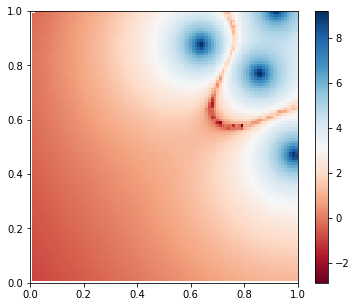

In [597]:
fig,ax = make_plot(df_test.values[0:10000,],use_log=True)

In [598]:
yt = model.predict(X_test)
yt = scaler_target.inverse_transform(yt)

In [609]:
pd.DataFrame(X_test).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.269704,0.315894,0.634473,0.873246,-1.0,0.916699,0.999013,1.0,0.853745,0.767402,1.0,0.984302,0.46895,-1.0
1,0.902666,0.159617,0.634473,0.873246,-1.0,0.916699,0.999013,1.0,0.853745,0.767402,1.0,0.984302,0.46895,-1.0
2,0.164854,0.308298,0.634473,0.873246,-1.0,0.916699,0.999013,1.0,0.853745,0.767402,1.0,0.984302,0.46895,-1.0
3,0.451398,0.165205,0.634473,0.873246,-1.0,0.916699,0.999013,1.0,0.853745,0.767402,1.0,0.984302,0.46895,-1.0
4,0.676185,0.088753,0.634473,0.873246,-1.0,0.916699,0.999013,1.0,0.853745,0.767402,1.0,0.984302,0.46895,-1.0


In [599]:
data_test_est = np.hstack((yt,X_test))
data_test_act = np.hstack((Y_test,X_test))
df_test_est = pd.DataFrame(data_test_est)
df_test_act = pd.DataFrame(data_test_act)

In [600]:
d1 = pd.DataFrame(np.hstack((yt,Y_test)))

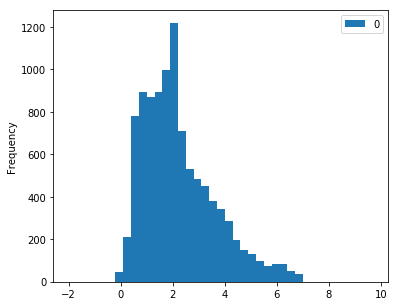

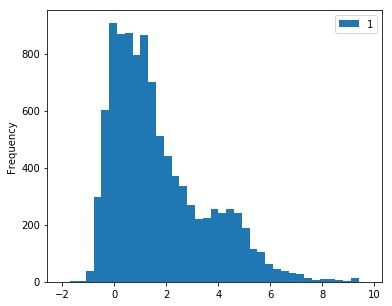

In [601]:
d1[[0]].plot(kind='hist',bins=np.arange(-2,10,0.3))
d1[[1]].plot(kind='hist',bins=np.arange(-2,10,0.3))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2. Use scipy.interpolate.griddata instead.
  if sys.path[0] == '':


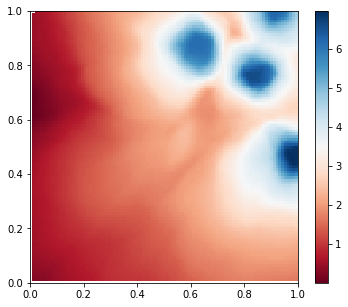

In [606]:
fig,ax = make_plot(df_test_est.values[0:10000,],use_log=False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2. Use scipy.interpolate.griddata instead.
  if sys.path[0] == '':


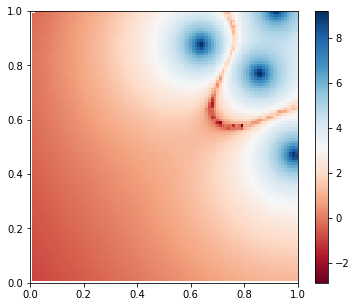

In [607]:
fig,ax = make_plot(df_test_act.values[0:10000,],use_log=False)

In [576]:
def deterministic_result(input_matrix):
    
    position_matrix = input_matrix[:,0:2]
    charge_matrix = input_matrix[0,2:]
    
    num_of_samples = input_matrix.shape[0]
    num_of_charges = int((input_matrix.shape[1]-2)/3.0)
    C = charge_matrix.flatten()
    charge_matrix = charge_matrix.T.reshape(-1,3)


    result = []
    for isam in range(0,num_of_samples):
        f = 0.0
        x = position_matrix[isam,0]
        y = position_matrix[isam,1]

        # Average over all the charges
        for ic in range(0,num_of_charges):
            dist = scipy.spatial.distance.euclidean(charge_matrix[ic,0:2],position_matrix[isam,0:2])
            f += (charge_matrix[ic,2]/(dist*dist))
            
        P = np.array([f,x,y])
        arr = np.hstack((P,C))
        result.append(arr)
        
    result = np.array(result)
    cols = ['f','x','y']
    for ic in range(0,num_of_charges):
        cols += ['C'+str(ic)+'x','C'+str(ic)+'y','C'+str(ic)+'q']
    #print(result.shape)
    return pd.DataFrame(result,columns=cols)

def nn_result(model,
              input_matrix,
              scaler_target):
    yt = model.predict(input_matrix)
    #yt = scaler_target.inverse_transform(yt)
    return yt

In [577]:
input_matrix = np.array((1.0,1.0,
                         0.1,0.4,1.0,
                         0.2,0.1,-1.0,
                         0.3,0.1,1.0,
                         0.4,0.1,-1.0)).reshape(1,-1)
input_matrix2 = np.vstack((input_matrix,input_matrix))
input_matrix3 = X[0,:].reshape(1,-1)

In [578]:
res = deterministic_result(input_matrix3)

In [579]:
res_nn = nn_result(model,input_matrix3,scaler_target)

In [580]:
def evaluate_performance(test_index,X,Y,scaler_target,model):
    Xt = X[test_index,:].reshape(1,-1)
    yt = model.predict(Xt)
    yt = scaler_target.inverse_transform(yt)
    res = deterministic_result(Xt)
    print('Estimate from NN:')
    print(yt[0][0])
    print('Real value from test data:')
    print(Y[test_index][0])
    print('Real value generated (a posteriori):')
    print(np.log(np.abs(res['f'][0])))

In [614]:
evaluate_performance(500,X,Y,scaler_target,model)

Estimate from NN:
1.18335
Real value from test data:
0.679211287436
Real value generated (a posteriori):
0.679211287436
